This notebook collects the scripts used in the analysis of the dinucleotides' trajectories reported in

Pinamonti, G., Zhao, J., Condon, D.E., Paul, F., Noe, F., Turner, D.H., Bussi, G., (2016) "Studying the\
 kinetic properties of RNA oligonucleotides with Markov state models", submitted

Please cite us if using this data or any of these analysis tools.


Input MD data can be downloaded from
https://drive.google.com/open?id=0B5ljL0_IChrSSlFqUlZYelVuLWc

In [2]:
# Useful stuff
import sys
import cPickle as pickle
import time
import numpy as np

# PyEmma
import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl

# plot
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline

# my scripts
import my_tools as my
import readwrite as rw
import gvec_func as gv
import pvec_func as pv
import dihedrals_func as dih

# 1 - Input, TICA and clustering

## 1.1 - Input data:


*Defining input file names*

In [3]:
multi_trajfiles=[]; multi_topfiles=[]
multi_names=['CpC','ApC','CpA','ApA',\
             'CpC-300K','ApC-300K','CpA-300K','ApA-300K',\
             ]
multi_colors=['blue','yellow','green','red',\
              'royalblue','y','limegreen','magenta',\
              'cyan','gold','darkolivegreen','pink']
directo='MD-data/dino/run_277K_1M/'
for name in multi_names[:4]:
    trajfiles=[]
    for i in range(1,5): trajfiles.append(directo+'/'+name+'/traj-strip_'+str(i)+'.xtc')
    topfile=directo+'/'+name+'/'+name+'.gro'
    multi_trajfiles.append(trajfiles); multi_topfiles.append(topfile)

directo='MD-data/dino/run_300K_1M/'
for name in multi_names[:3]:
    trajfiles=[]
    for i in range(1,3): 
        for j in range(1,5): 
            trajfiles.append(directo+'/'+name+'/traj-strip_'+str(i)+'_'+str(j)+'.xtc')
    topfile=directo+'/'+name+'/'+name+'.gro'
    multi_trajfiles.append(trajfiles); multi_topfiles.append(topfile)


directo='MD-data/dino/run_300K_1M/ApA/'
trajfiles=[]
for i in range(1,5):
    for l in range(4):
        trajfiles.append(directo+'/traj-strip_'+str(i)+'_'+str(l)+'.xtc')
topfile=directo+'ApA.gro'
multi_trajfiles.append(trajfiles); multi_topfiles.append(topfile)

*Reading the files*

As input coordinates we consider:
1. G-vectors (as described in Bottaro et al., 2014, NAR)
2. backbone dihedrals, sugar puckering angles, glycosidic torsionals

In [4]:
start_time = time.time()
##############################################################################
multi_feat_dGP=[]; multi_inp_dGP=[]; multi_traj_dGP=[];\
multi_inpXout=[];multi_featXout=[]
for imol in range(len(multi_names)):
    name=multi_names[imol];topfile=multi_topfiles[imol];trajfiles=multi_trajfiles[imol]
    #print '*****************'
    print '\nMOLECULE:',name
    #print '*****************'
    
    feat_dGP=coor.featurizer(topfile)
    nres=2; feat_dGP.add_custom_func(gv.get_gvecs,4*nres*nres)
    top=feat_dGP.topology
    lista_dihedrals=dih.get_dihedrals_ndx(top)
    for ll in lista_dihedrals: feat_dGP.add_dihedrals(ll,cossin=True,periodic=False)
    lista_pucker=dih.get_pucker_ndx(top)
    for ll in lista_pucker: feat_dGP.add_dihedrals(ll,cossin=True,periodic=False)
    lista_chis=dih.get_chi_ndx(top)
    feat_dGP.add_dihedrals(lista_chis,cossin=True,periodic=False)
    inp_dGP = coor.source(trajfiles, feat_dGP)

    #### Files for output structures
    featXout=coor.featurizer(topfile); featXout.add_all()
    inpXout = coor.source(trajfiles, featXout)

    multi_featXout.append(featXout);multi_inpXout.append(inpXout)
    multi_feat_dGP.append(feat_dGP);multi_inp_dGP.append(inp_dGP)
    
    ### comment the next two lines if you already computed and saved TICA-trajs
    traj_dGP=coor.load(trajfiles,feat_dGP,chunk_size=1000,stride=1)
    multi_traj_dGP.append(traj_dGP)
##############################################################################
print("\nFinito\n--- %s seconds ---" % (time.time() - start_time))


MOLECULE: CpC
getting output of FeatureReader: 100% (968/968) [##################] eta 00:01 |
MOLECULE: ApC
getting output of FeatureReader: 100% (968/968) [##################] eta 00:01 |
MOLECULE: CpA
getting output of FeatureReader: 100% (912/912) [##################] eta 00:01 |
MOLECULE: ApA
getting output of FeatureReader: 100% (896/896) [##################] eta 00:01 |
MOLECULE: CpC-300K
getting output of FeatureReader: 100% (704/704) [##################] eta 00:01 |
MOLECULE: ApC-300K
getting output of FeatureReader: 100% (704/704) [##################] eta 00:01 |
MOLECULE: CpA-300K
getting output of FeatureReader: 100% (664/664) [##################] eta 00:01 |
MOLECULE: ApA-300K
getting output of FeatureReader: 100% (704/704) [##################] eta 00:01 |
Finito
--- 3995.46230698 seconds ---


In [5]:
for imol in range(len(multi_names)):
    print '*** Molecule:', multi_names[imol]
    inp_dGP=multi_inp_dGP[imol]
    print 'N. trajectories = %d' % inp_dGP.ntraj
    print 'N. frames = %d' % inp_dGP.n_frames_total()
    print 'Total length = %.1f microseconds' % (inp_dGP.n_frames_total()/100000.)
    print

*** Molecule: CpC
N. trajectories = 4
N. frames = 964136
Total length = 9.6 microseconds

*** Molecule: ApC
N. trajectories = 4
N. frames = 965904
Total length = 9.7 microseconds

*** Molecule: CpA
N. trajectories = 4
N. frames = 908576
Total length = 9.1 microseconds

*** Molecule: ApA
N. trajectories = 4
N. frames = 892456
Total length = 8.9 microseconds

*** Molecule: CpC-300K
N. trajectories = 8
N. frames = 699184
Total length = 7.0 microseconds

*** Molecule: ApC-300K
N. trajectories = 8
N. frames = 698756
Total length = 7.0 microseconds

*** Molecule: CpA-300K
N. trajectories = 8
N. frames = 659424
Total length = 6.6 microseconds

*** Molecule: ApA-300K
N. trajectories = 16
N. frames = 700576
Total length = 7.0 microseconds



## 1.2 - TICA analysis

The TICA analysis is performed on the "merged" data set, i.e. putting all the trajectories together and treating them as being one single system.

This can be done because they all share the same number of coordinates (G-vectors are the same and dihedrals are the same)

In [6]:
%time tica_obj=coor.tica(data=[traj for moltrajs in multi_traj_dGP \
                               for traj in moltrajs],lag=100)
tica_dim,cumvar=my.get_tica_cumvar(tica_obj)
print 'TICA dimensions = %d (%d)'%(tica_dim,tica_obj.dimension())

calculate mean+cov: 100% (1324/1324) [#############################] eta 00:01 |CPU times: user 1min 49s, sys: 3.46 s, total: 1min 52s
Wall time: 9.91 s
TICA dimensions = 10 (10)


In [7]:
multi_tica_traj=[]
for imol in range(len(multi_names)):
    multi_tica_traj.append(tica_obj.transform(multi_traj_dGP[imol]))
    ### Use this to save the TICA trajectories on disk to use them later
    #rw.write_tica_trajs('dino-'+multi_names[imol]+'_lt100',multi_tica_traj[imol])

### Use this to read previously saved tica trajectories
#multi_tica_traj=[]
#for imol in range(len(multi_names)):
#    ntrajs=multi_inp_dGP[imol].ntraj
#    multi_tica_traj.append(rw.read_tica_trajs('dino-'+multi_names[imol]+'_lt100',ntrajs))

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


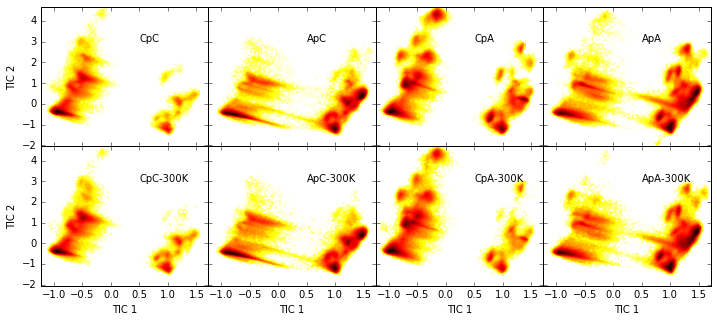

In [8]:
ix=0
iy=1
nmols=len(multi_names)
f, axes = plt.subplots(nmols/4,4, \
        figsize=(12,5),sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
for imol in range(len(multi_names)):
    ax=axes[imol/4,imol%4]
    name=multi_names[imol]
    
    Ytot=np.concatenate(multi_tica_traj[imol])
    z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
    F = -np.log(z)
    del Ytot
    extent = [x[0], x[-1], y[0], y[-1]]   
    ax.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
    ax.text(0.5,3,name)
    if imol/4==nmols/4-1: 
        ax.set_xlabel('TIC 1')
    if imol%4==0: 
        ax.set_ylabel('TIC 2')

From the plot above we see that the TICA space spanned by the 8 systems is qualitatively similar. This enables us to perform a discretization of the merged dataset (using k-means algorithm)

In [9]:
# These are the positions in the TICA space of the canonical, A-form, structures
multi_tica_native=[]
for imol in range(4):
    frame_native=coor.load('MD-data/dino/'\
                           +multi_names[imol]+'_initial_dumb.xtc',features=multi_feat_dGP[imol])
    tica_native=tica_obj.transform(frame_native); multi_tica_native.append(tica_native)

## 1.3 - Clustering

In [10]:
### Clustering with k-means
%time cl = coor.cluster_kmeans(data=[X[:,0:tica_dim] for moltrajs in multi_tica_traj \
                                     for X in moltrajs],\
                               k=400,stride=1,max_iter=50,fixed_seed=True)
### Use this if you wanna save the centers on disk
#rw.write_cl_centers('dino_lt100_k400',cl); rw.write_cl_indexes('dino_lt100_k400',cl)
cl_centers=cl.clustercenters

### Use this to read previously saved k-means centers
#cl_centers=rw.read_cl_centers('multi_lt100_k400')

kmeans iterations:   6% ( 3/50) [#                               ] eta 1:31:31 \04-10-16 13:12:19 pyemma.coordinates.clustering.kmeans.KmeansClustering[13] INFO     Cluster centers converged after 4 steps.
kmeans iterations: 100% (50/50) [################################] eta 1:29:33 -CPU times: user 16min 10s, sys: 935 ms, total: 16min 11s
Wall time: 16min 13s


After the k-means clustering is performed on the merged data set, we assign the "discrete trajectories" separately for each system

In [11]:
multi_dtrajs=[]
for imol in range(len(multi_names)): 
    multi_dtrajs.append(cl.assign(X=multi_tica_traj[imol]))
    ### use this to save the discrete-trajectories
    #rw.write_cl_dtrajs('dino-'+multi_names[imol]+'_lt100_k400',multi_dtrajs[imol])
    ### Use this to read previously saved discrete-trajectories
    #multi_dtrajs.append(rw.read_cl_dtrajs('multi'+multi_names[imol]+'_lt100_k400',multi_inp_dGP[imol].ntraj))

Now let's visualize all this together on the first 2-TICs plane

In [12]:
ix=0;iy=1
Ytot=np.concatenate([traj for moltrajs in multi_tica_traj for traj in moltrajs])
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F = -np.log(z);del Ytot;extent = [x[0], x[-1], y[0], y[-1]]

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


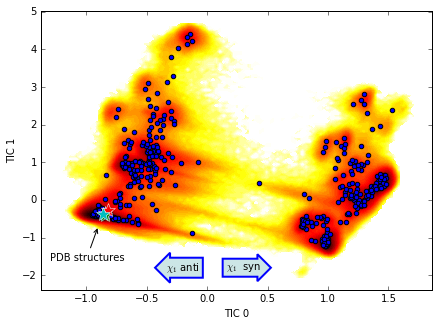

In [13]:
ix=0; iy=1
plt.figure(figsize=(7,5))
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plt.scatter(cl_centers[:,ix],cl_centers[:,iy])

plt.xlabel('TIC '+str(ix)); plt.ylabel('TIC '+str(iy))
bbox_props = dict(boxstyle="rarrow", fc=(0.8,0.9,0.9), ec="b", lw=2)
plt.text(0.3, -1.8, r'$\chi_1$  syn', ha="center", va="center", \
         rotation=0,size=10,bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc=(0.8,0.9,0.9), ec="b", lw=2)
plt.text(-0.2, -1.8, r'$\chi_1$ anti', ha="center", va="center", \
         rotation=0,size=10,bbox=bbox_props)
y_range=plt.ylim()
x_range=plt.xlim()
for imol in range(4):
    plt.plot(multi_tica_native[imol][0,ix],multi_tica_native[imol][0,iy],\
             ls='',marker='*',markersize=15,markeredgecolor='white')
plt.annotate('PDB structures', xy=(-0.9, -0.7), xytext=(-1.3, -1.6),\
             arrowprops=dict(facecolor='black', arrowstyle='->'))

## 1.4 - Implied timescales analysis

Looking at the convergence of the implied timescales we test the Markovianity of the MSMs

In [14]:
multi_its=[]
for imol in range(len(multi_names)):
    multi_its.append(msm.its(multi_dtrajs[imol],lags=[1,5,10,20,30,40,50,60,80,100],nits=15))
    #rw.write_msm_its('dino-'+multi_names[imol]+'_lt100_k400',multi_its[imol])

estimating MaximumLikelihoodMSM: 100% (10/10) [####################] eta 00:01 -

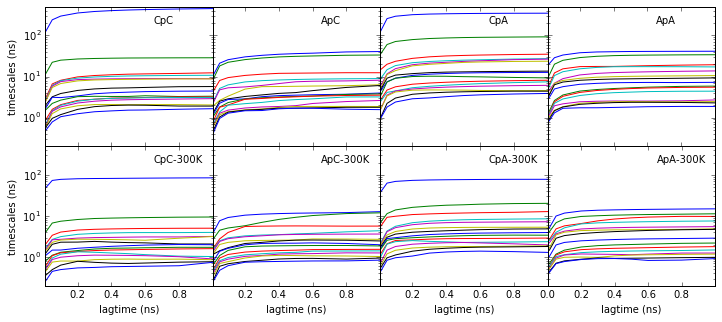

In [15]:
nmols=len(multi_names)
f, axes = plt.subplots(nmols/4,4, \
        figsize=(12,5),sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
for imol in range(len(multi_names)):
    ax=axes[imol/4,imol%4]
    ax.plot(multi_its[imol].lags/100.,multi_its[imol].timescales/100.)
    ax.text(0.65,200,multi_names[imol])
    ax.set_yscale('log')
    if imol%4==0: ax.set_ylabel('timescales (ns)')
    if imol/4==1: ax.set_xlabel('lagtime (ns)')
    ax.set_xticks(np.arange(0.0,0.9,0.2))
    ax.set_ylim(0.2,500)

All of the ITS are converging after a few tenths of ns. Good!

# 2 - Markov State Model

## 2.1 - Timescales and active set of microstates

The MSM are build chosing a lagtime of 0.5 ns

In [16]:
multi_M=[]
for imol in range(len(multi_names)):
    M=msm.estimate_markov_model(multi_dtrajs[imol],50)
    #rw.write_msm('dino-'+multi_names[imol]+'_lt100_k400_lm50',M)
    ### If you already computed and saved MSMs read them with this
    #M=rw.read_msm('dino-'+multi_names[imol]+'_lt100_k400_lm50')
    ###
    multi_M.append(M)
    print '***',multi_names[imol],'***'
    print 'Active states fraction=%.2f' % M.active_state_fraction
    print 'Active counts fraction=%.2f' % M.active_count_fraction
    print 'First timescales: %4.f %4.f %4.f (ns)' % \
    (M.timescales()[0]/100,M.timescales()[1]/100,M.timescales()[2]/100)

*** CpC ***
Active states fraction=0.92
Active counts fraction=1.00
First timescales:  418   28   11 (ns)
*** ApC ***
Active states fraction=0.94
Active counts fraction=1.00
First timescales:   36   31   12 (ns)
*** CpA ***
Active states fraction=0.95
Active counts fraction=1.00
First timescales:  342   89   33 (ns)
*** ApA ***
Active states fraction=0.99
Active counts fraction=1.00
First timescales:   41   33   18 (ns)
*** CpC-300K ***
Active states fraction=0.94
Active counts fraction=1.00
First timescales:   83    9    5 (ns)
*** ApC-300K ***
Active states fraction=0.94
Active counts fraction=1.00
First timescales:   12    9    6 (ns)
*** CpA-300K ***
Active states fraction=0.96
Active counts fraction=1.00
First timescales:   77   19   12 (ns)
*** ApA-300K ***
Active states fraction=0.99
Active counts fraction=1.00
First timescales:   14   11    9 (ns)


In [17]:
for imol in range(len(multi_names)):
    print '%s: %d active states'%(multi_names[imol],multi_M[imol].nstates)
from functools import reduce
common_active_set=reduce(np.intersect1d,[M.active_set for M in multi_M])
print
print 'N. of states in common is %d (%2.f%% of the total)'\
%(len(common_active_set),len(common_active_set)/float(400)*100)

CpC: 367 active states
ApC: 374 active states
CpA: 381 active states
ApA: 397 active states
CpC-300K: 377 active states
ApC-300K: 375 active states
CpA-300K: 383 active states
ApA-300K: 398 active states

N. of states in common is 319 (80% of the total)


A large percentage of the microstates is in common between all the MSMs. This is good because it means that we can compare the MSMs of different molecules.

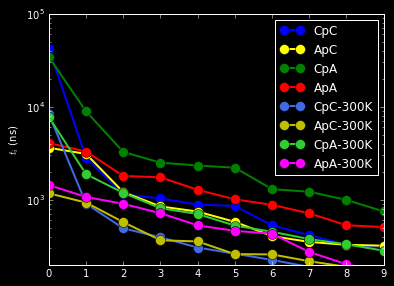

In [18]:
nevec=10
with plt.style.context(('dark_background')):
    plt.figure(figsize=(6,4.5))
    for imol in range(len(multi_names)):
        M=multi_M[imol]
        plt.plot(M.timescales()[:nevec],marker='o',\
                 color=multi_colors[imol],label=multi_names[imol],lw=2,ms=10)
    plt.yscale('log')
    plt.ylabel('$t_i$ (ns)')
    plt.legend()
    plt.ylim(200,100000)

##### STATISTICAL ERRORS FROM BAYESIAN SAMPLING OF TRANSITONS MATRIX

In [19]:
multi_BM=[]
for imol in range(len(multi_names)):
    M=multi_M[imol]
    dtrajs=M.discrete_trajectories_full
    BM=msm.bayesian_markov_model(dtrajs,50)
    multi_BM.append(BM)

Sampling MSMs: 100% (100/100) [####################################] eta 00:01 -

In [20]:
multi_bm_timescales=[]
for imol in range(len(multi_names)):
    BM=multi_BM[imol]
    bm_timescales_std=BM.sample_std('timescales')
    multi_bm_timescales.append(bm_timescales_std)

In [21]:
for imol in range(len(multi_names)):
    M=multi_M[imol]
    BM=multi_BM[imol]
    bm_timescales_std=multi_bm_timescales[imol]
    print '***',multi_names[imol],'***'
    print 'First timescales: %4.f +- %2.1f %4.f +- %2.1f %4.f +- %2.1f (ns)' % \
    (M.timescales()[0]/100,bm_timescales_std[0]/100,\
     M.timescales()[1]/100,bm_timescales_std[1]/100,\
     M.timescales()[2]/100,bm_timescales_std[2]/100,)

*** CpC ***
First timescales:  418 +- 49.0   28 +- 2.5   11 +- 2.7 (ns)
*** ApC ***
First timescales:   36 +- 6.4   31 +- 1.1   12 +- 2.4 (ns)
*** CpA ***
First timescales:  342 +- 16.3   89 +- 4.8   33 +- 3.6 (ns)
*** ApA ***
First timescales:   41 +- 2.9   33 +- 0.5   18 +- 0.6 (ns)
*** CpC-300K ***
First timescales:   83 +- 4.5    9 +- 0.4    5 +- 0.0 (ns)
*** ApC-300K ***
First timescales:   12 +- 0.1    9 +- 1.2    6 +- 0.3 (ns)
*** CpA-300K ***
First timescales:   77 +- 4.4   19 +- 0.6   12 +- 1.1 (ns)
*** ApA-300K ***
First timescales:   14 +- 0.2   11 +- 0.9    9 +- 0.8 (ns)


## 2.2 - Eigenvectors analysis:

We analyses the eigenvectors by computing their scalar products

In [22]:
nevec=3
nmols=len(multi_names)
evec_scal_prod=np.zeros((nevec*nmols,nevec*nmols))
for imol1 in range(nmols):
    for imol2 in range(nmols):
        for icomp1 in range(1,1+nevec):
            for icomp2 in range(1,1+nevec):

                M1=multi_M[imol1]
                M2=multi_M[imol2]
                v1=np.zeros(400)
                v1[M1.active_set]=M1.eigenvectors_right()[:,icomp1]*\
                np.sqrt(M1.eigenvectors_left()[0,:])
                v2=np.zeros(400)
                v2[M2.active_set]=M2.eigenvectors_right()[:,icomp2]*\
                np.sqrt(M2.eigenvectors_left()[0,:])
                #NB: I multiply by the stat. dist. to have orthonormal vectors
                temp_prod=np.dot(v1,v2)/np.sqrt(np.sum(v1**2)*np.sum(v2**2))
                evec_scal_prod[nevec*imol1+icomp1-1,nevec*imol2+icomp2-1]=temp_prod

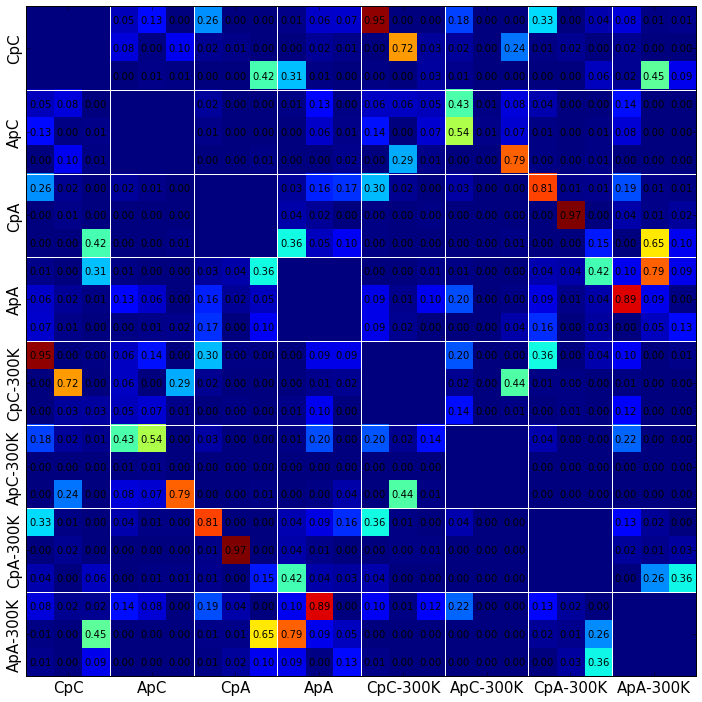

In [23]:
plt.figure(figsize=(0.5*nmols*nevec,0.5*nmols*nevec))
plt.imshow(evec_scal_prod**2-np.diag(np.ones(nevec*nmols)),cmap=plt.cm.jet, 
                interpolation='nearest')
xt=plt.xticks(range(1,nmols*nevec,nevec),multi_names,fontsize=15) 
yt=plt.yticks(range(1,nmols*nevec,nevec),multi_names,rotation='vertical',fontsize=15)

for i in range(nmols):
    plt.plot([nevec*i-0.5,nevec*i-0.5],[-0.5,nevec*nmols-0.5],color='white')
for i in range(nmols):
    plt.plot([-0.5,nevec*nmols-0.5],[nevec*i-0.5,nevec*i-0.5],color='white')
for imol1 in range(nmols):
    for imol2 in range(nmols):
        if imol1==imol2:
            continue
        for i1 in range(nevec):
            for i2 in range(nevec):
                x=imol1*nevec+i1
                y=imol2*nevec+i2                
                plt.annotate(str('%1.2f'% evec_scal_prod[x,y]**2), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

#### Kernel PCA:

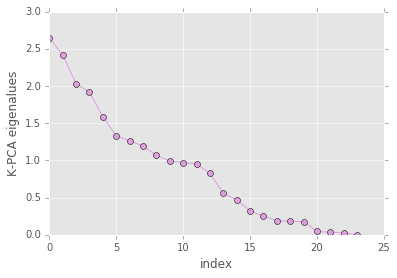

In [34]:
### I define phi_i=np.outer(v_i,v_i)
K=evec_scal_prod**2 #this is the matrix of phi_i dot phi_j (equivalent to (v_i dot v_i)^2 )
N1=np.ones(K.shape)/K.shape[0]
K=K-np.dot(N1,K)-np.dot(K,N1)+np.dot(N1,np.dot(K,N1)) #this is to normalize K so that avg(phi_i)=0
from scipy.linalg import eigh
k_pca=eigh(K)
with plt.style.context(('ggplot')):
    plt.plot(k_pca[0][::-1],marker='o',color='plum')
    plt.xlabel('index')
    plt.ylabel('K-PCA eigenalues')

evec_proj=(k_pca[1][:,::-1])
vec_names=[]
for imol in range(nmols):
    for icomp in range(1,nevec+1):
        vec_names.append(str(icomp))

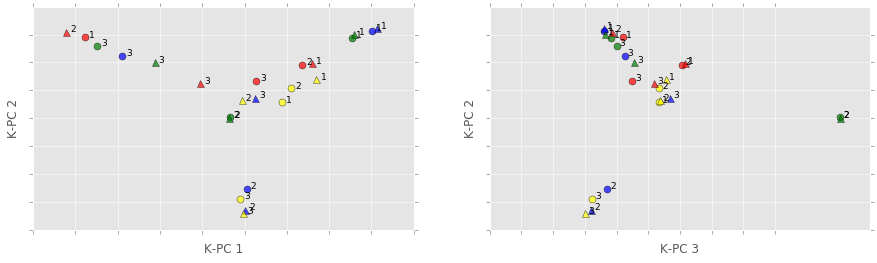

In [35]:
with plt.style.context(('ggplot')):
    plt.figure(figsize=(15,4))
    ix=0;iy=1
    plt.subplot2grid((1,2),(0,0))
    nevec=3
    markers=['o','^','s']
    for imol in range(nmols):
        for icomp in range(1,nevec+1):
            plt.plot(evec_proj[imol*nevec+icomp-1,ix],evec_proj[imol*nevec+icomp-1,iy],\
                    color=multi_colors[imol%4],markersize=7,label=multi_names[imol],\
                marker=markers[imol/4],alpha=0.7)
        
            plt.annotate(str(icomp),\
                    (evec_proj[imol*nevec+icomp-1,ix]+0.01,evec_proj[imol*nevec+icomp-1,iy]),\
                    fontsize=9)    
    plt.xticks(np.arange(-0.5,0.5,0.1),[])
    plt.yticks(np.arange(-0.5,0.3,0.1),[])
    plt.xlabel('K-PC 1')
    plt.ylabel('K-PC 2')
    ix=2;iy=1
    plt.subplot2grid((1,2),(0,1))
    nevec=3
    markers=['o','^','s']
    for imol in range(nmols):
        for icomp in range(1,nevec+1):
            plt.plot(evec_proj[imol*nevec+icomp-1,ix],evec_proj[imol*nevec+icomp-1,iy],\
                    color=multi_colors[imol%4],markersize=7,label=multi_names[imol],\
                marker=markers[imol/4],alpha=0.7)
        
            plt.annotate(str(icomp),\
                    (evec_proj[imol*nevec+icomp-1,ix]+0.01,evec_proj[imol*nevec+icomp-1,iy]),\
                    fontsize=9)    
    plt.xticks(np.arange(-0.5,0.5,0.1),[])
    plt.yticks(np.arange(-0.5,0.3,0.1),[])
    plt.xlabel('K-PC 3')
    plt.ylabel('K-PC 2')

From these projection on this KPCA space we can already identify some groups of eigenvector that share similar features. But let's do something else...

## Analysis of the correlations between eigenvectors and input coordinates

In [40]:
dih_names=[]
### BACKBONE DIHEDRALS
for lll,name in zip(lista_dihedrals,[r'\alpha',r'\beta',r'\gamma',r'\delta',r'\epsilon',r'\zeta']):
    for i in range(len(lll)):
        if name=='\alpha' or name=='\beta':
            dih_names.append(r'$'+name+'_'+str(i+2)+'$')
        else:
            dih_names.append(r'$'+name+'_'+str(i+1)+'$')
### PUCKERING ANGLES
for lll,name in zip(lista_pucker,[r'\nu^0',r'\nu^1',r'\nu^2',r'\nu^3',r'\nu^4']):
    for i in range(len(lll)):
        dih_names.append(r'$'+name+'_'+str(i+1)+'$')
### CHI ANGLES
lll=lista_chis
name=r'\chi'
for i in range(len(lll)):
    dih_names.append(r'$'+name+'_'+str(i+1)+'$')
print 'There are %d dihedrals' % len(dih_names)

There are 20 dihedrals


In [41]:
##############################################################################
multi_feat_dih=[]; multi_inp_dih=[]; multi_traj_dih=[]
for imol in range(nmols):
    name=multi_names[imol];topfile=multi_topfiles[imol];trajfiles=multi_trajfiles[imol]
    
    feat_dih=coor.featurizer(topfile)
    top=feat_dih.topology
    lista_dihedrals=dih.get_dihedrals_ndx(top)
    for ll in lista_dihedrals: feat_dih.add_dihedrals(ll,cossin=False,periodic=False)
    lista_pucker=dih.get_pucker_ndx(top)
    for ll in lista_pucker: feat_dih.add_dihedrals(ll,cossin=False,periodic=False)
    lista_chis=dih.get_chi_ndx(top)
    feat_dih.add_dihedrals(lista_chis,cossin=False,periodic=False)
    inp_dih = coor.source(trajfiles, feat_dih)

    traj_dih=coor.load(trajfiles,feat_dih,chunk_size=1000,stride=1)
    multi_feat_dih.append(feat_dih);multi_inp_dih.append(inp_dih)
    multi_traj_dih.append(traj_dih)
##############################################################################

getting output of FeatureReader: 100% (704/704) [##################] eta 00:01 \

We can't compute the correlation between the eigenvector and an angle (because the mean of an angle is not well defined due to its periodicity). 

So we decided to use the cosine. But this means that we will miss a correlation if for example the process is rotating the torsional from -90 to 90.

Therefore we add a phase, ("fase" in the script), to shift the torsional and select the maximum correlation.

In [42]:
start_time = time.time()
multi_maxcorr_evec_var=[]
multi_fmax_evec_var=[]
for imol in range(nmols): 
    M=multi_M[imol]
    traj_dih=multi_traj_dih[imol]
    dtrajs=M.discrete_trajectories_active
    m_maxcorr_evec_var=[]
    m_fmax_evec_var=[]
    for icomp in range(1,nevec+1):
        trajtot_evec=np.concatenate([np.array([M.eigenvectors_right()[icl,icomp] for icl in dt]) for dt in dtrajs])
        
        maxcorr_evec_var=[]
        fmax_evec_var=[]
        for ivar in range(len(dih_names)):
            ccc=[]
            n_fette=12
            for i in range(n_fette):
                fase=(np.pi/n_fette)*i
                trajtot_dih=np.cos(np.concatenate(traj_dih)[:,ivar]+fase)
                ccc.append(np.corrcoef(trajtot_evec,trajtot_dih)[0,1])
            fmax_evec_var.append(np.argmax(np.abs(ccc))*np.pi/n_fette)
            maxcorr_evec_var.append(np.max(np.abs(ccc)))
        m_maxcorr_evec_var.append(np.array(maxcorr_evec_var))
        m_fmax_evec_var.append(np.array(fmax_evec_var))
    multi_maxcorr_evec_var.append(np.array(m_maxcorr_evec_var))
    multi_fmax_evec_var.append(np.array(m_fmax_evec_var))
multi_maxcorr_evec_var=np.array(multi_maxcorr_evec_var)
multi_fmax_evec_var=np.array(multi_fmax_evec_var)
print("\nFinito\n--- %s seconds ---" % (time.time() - start_time))


Finito
--- 467.262983084 seconds ---


### Correlation between eigenvectors and dihedrals

Let's visualize them!

(I already grouped the processes, to make it easier to understand)

In [45]:
names=['A','B','C','D','E','F']
evec_groups=[[3,4,10,11,14,15,16,21],\
            [2,8,9,22],\
            [0,6,12,18],\
            [1,5,13,17],\
            [7,19],\
            [20,23]]

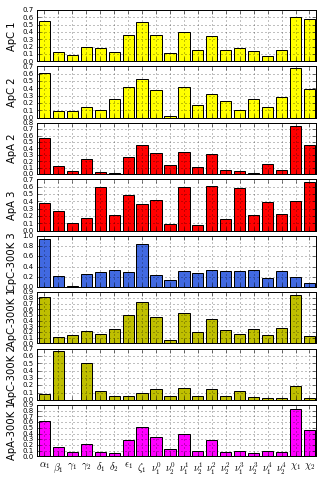

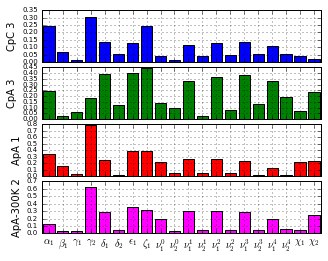

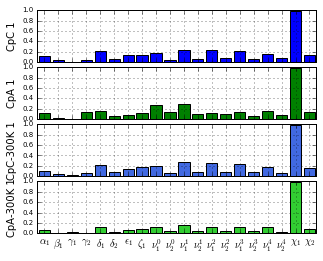

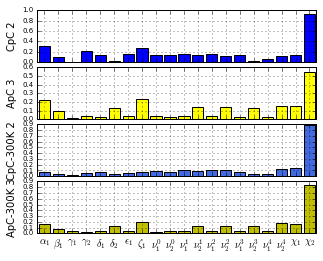

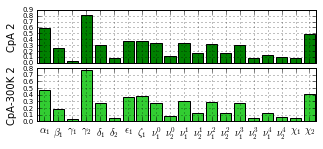

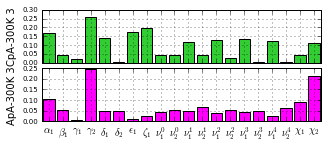

In [47]:
for icl in range(ncl):
    nevec=len(evec_groups[icl])
    fig=plt.figure(figsize=(5,nevec*1.))
    plt.subplots_adjust(hspace=0.1)
    plt.title('Group '+names[icl],fontsize=15)
    iplot=0
    for idx in evec_groups[icl]:        
        imol=idx/3
        icomp=idx%3+1
        m_corr_evec_var=multi_maxcorr_evec_var[imol]
        corr_evec_var=m_corr_evec_var[icomp-1]

        plt.subplot2grid((nevec,1),(iplot,0))
        plt.bar([x-0.4 for x in range(len(dih_names))],\
                np.abs(corr_evec_var),width=0.8,color=multi_colors[imol])
        yrange=plt.ylim()
        plt.grid()
        plt.ylabel(multi_names[imol]+' '+str(icomp))
        temp=plt.xticks(range(len(dih_names)),[])
        plt.xlim(-0.5,len(dih_names)-0.5)
        iplot+=1
        plt.yticks(fontsize=7)
        
    temp=plt.xticks(range(len(dih_names)),dih_names,fontsize=10)      

*NB: if you are running this and you want to understand what is going on in a particular process, you can use the cell below to print a certain eigenvector. It will produce two .pdb files, with 50 frames taken from the starting region (i.e. microstates where the eigenvector is negative) and the end region (positive eigenvector) of the process.*

### HOW TO: check with dump=False and tune the eps
Number of microstates: start -> 50   end -> 50
20-07-16 17:16:17 pyemma.coordinates.api INFO     Created file multi1M-ApC_lt100_k400_lm50_evec1-start.pdb
20-07-16 17:16:18 pyemma.coordinates.api INFO     Created file multi1M-ApC_lt100_k400_lm50_evec1-end.pdb


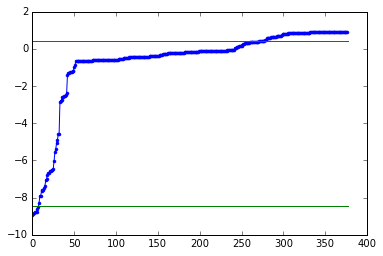

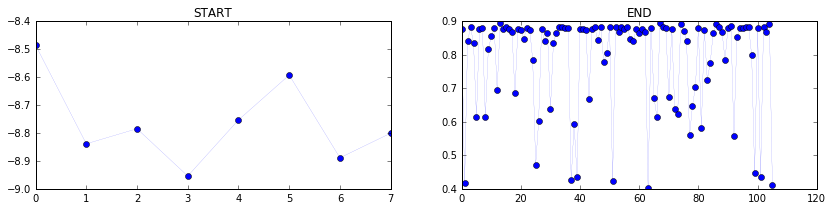

In [420]:
### Use this to dump frames from the start or end part of a given process
imol=1
icomp=1
my.dump_evec('dino-ApC_lt100_k400_lm50',multi_M[imol],multi_inpXout[imol],\
             icomp=1,dump=True,eps=0.5)

### Visualizing the eigenvectors on the 2-TICs plane

This is yet another way to visualize the eigenvectors

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/u/sbp/giopina/Dropbox/SISSA/software/pyemma_shortcuts/my_tools.py:219: RuntimeWarning: invalid value encountered in divide
  F/=NN


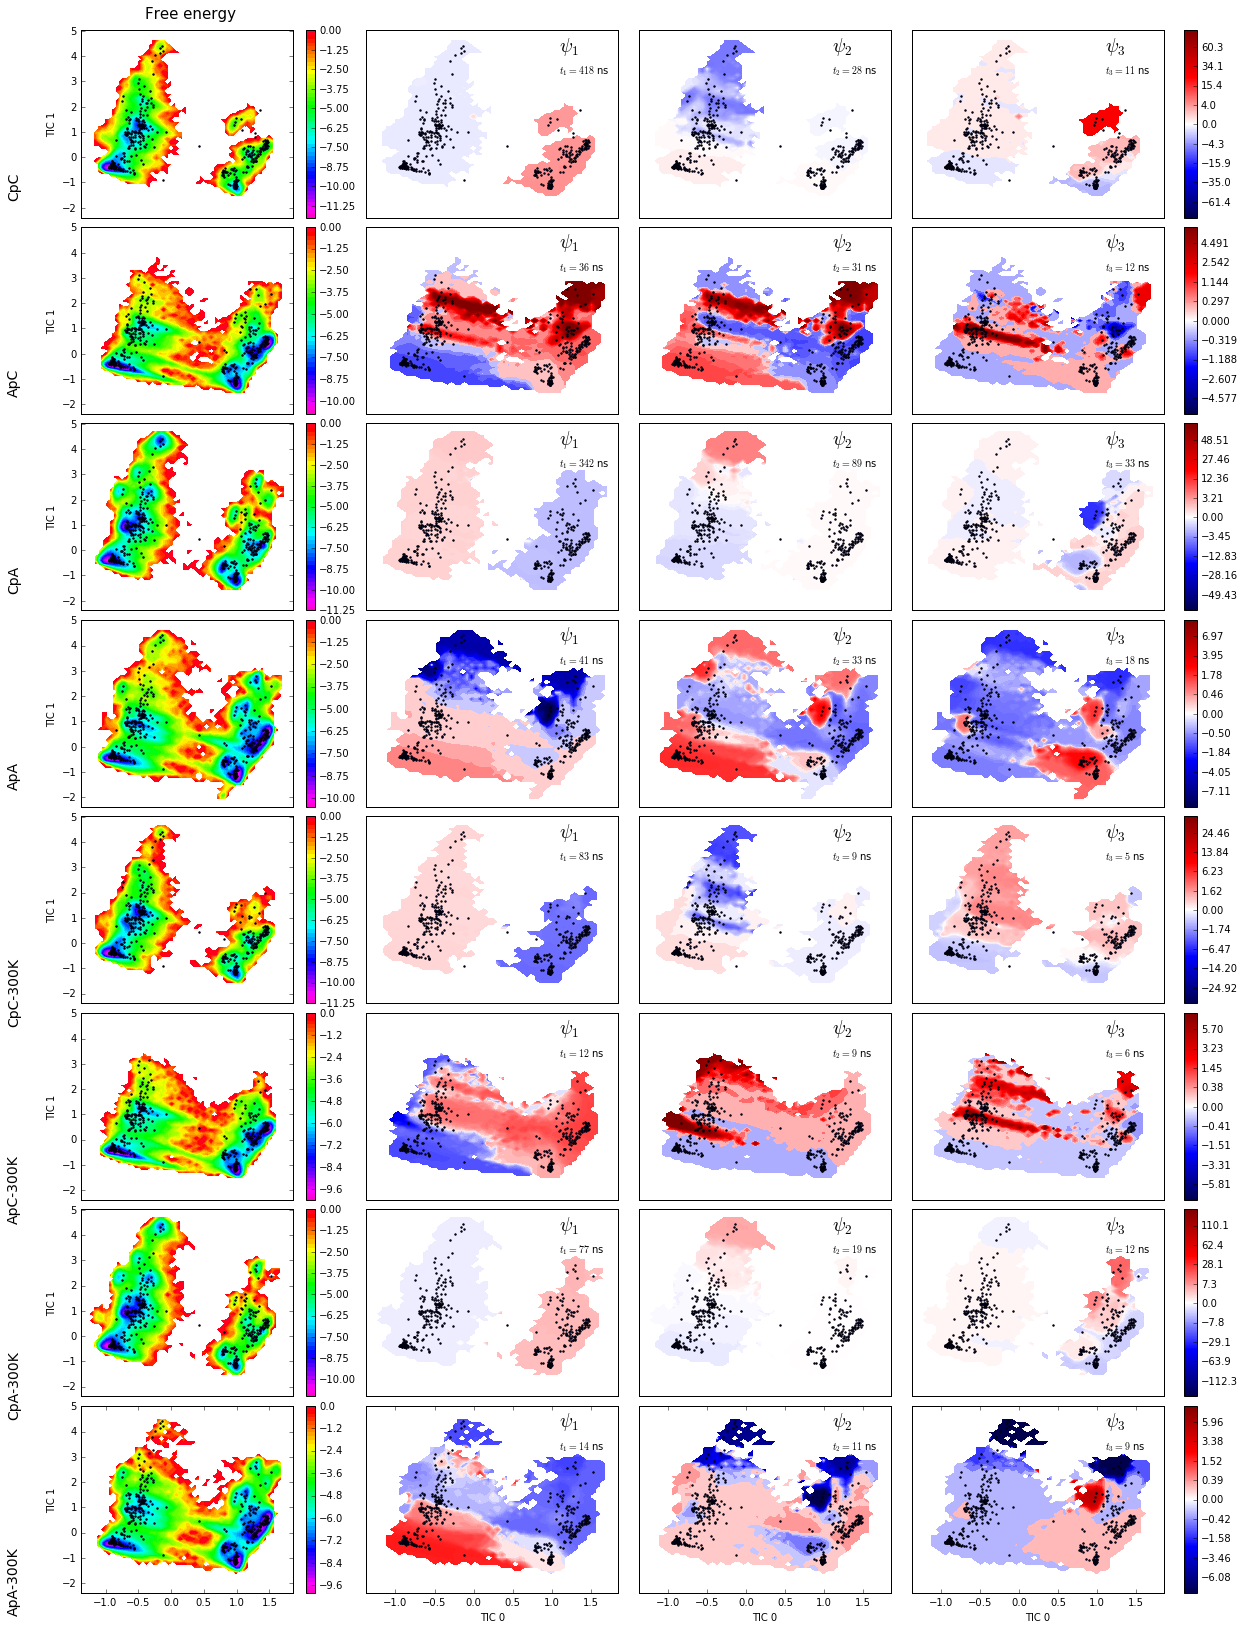

In [44]:
import matplotlib
import matplotlib.colors as pltcol
ix=0;iy=1
nevec=3
f, axes = plt.subplots(nmols,nevec+2, \
        gridspec_kw = {'width_ratios':[1.05]+[1 for x in range(nevec)]+[0.05]},\
        figsize=(20,3.5*nmols))#,sharey=True,sharex=True)

plt.subplots_adjust(hspace=0.05,wspace=0.1)
for imol in range(nmols):
    M=multi_M[imol]
    trajtot_tic=np.concatenate(multi_tica_traj[imol])[:,:]
    ax=axes[imol,0]
    z,x,y = np.histogram2d(trajtot_tic[:,0],trajtot_tic[:,1], bins=50)
    F = -np.log(z); extent = [x[0], x[-1], y[0], y[-1]]
    CS=ax.contourf(F.T, 50, cmap=plt.cm.gist_rainbow_r, extent=extent)
    cbar = plt.colorbar(CS,ax=ax)
    ax.scatter(cl_centers[M.active_set,ix], cl_centers[M.active_set,iy],s=2)
    ax.set_ylabel('TIC '+str(iy))
    ax.set_ylim(y_range); ax.set_xlim(x_range)
    if imol<nmols-1: ax.set_xticks([])
    if imol<nmols-1: ax.set_xticks([])
    ax.text(-2.5,-1.,multi_names[imol],fontsize=14,rotation='vertical')
    vmax=np.array([M.eigenvectors_right()[icomp] for icomp in range(1,nevec+1)]).max()
    vmin=np.array([M.eigenvectors_right()[icomp] for icomp in range(1,nevec+1)]).min()
    vmax=np.max(np.abs(np.array([vmax,vmin])))
    vmin=-vmax
    cmap=plt.cm.seismic
    #bound=np.exp(np.arange(1,cmap.N/2))
    bound=np.arange(1,cmap.N/2)**2
    bound=np.concatenate([-bound[:1:-1],bound])*vmax/bound[-1]
    norm=pltcol.BoundaryNorm(bound,cmap.N)
    for icomp in range(1,nevec+1):
        trajtot_evec=np.concatenate([np.array([M.eigenvectors_right()[icl,icomp] for icl in dt])\
                             for dt in M.discrete_trajectories_active])
        F,extent=my.plot_3traj(M,trajtot_tic[:,0],trajtot_tic[:,1],trajtot_evec[:],nbins=50)
        ax=axes[imol,icomp]
        CS=ax.contourf(F.T, 50, cmap=cmap, extent=extent,norm=norm)

        ax.scatter(cl_centers[M.active_set,ix], cl_centers[M.active_set,iy],s=2)
        
        ax.text(1.1,3.3,'$t_'+str(icomp)+'=%4.f$ ns' % (M.timescales()[icomp-1]/100))
        ax.text(1.1,4.2,r'$\psi_{'+str(icomp)+'}$',fontsize=19)   
        ax.set_ylim(y_range); ax.set_xlim(x_range)
        if imol<nmols-1: ax.set_xticks([])
        ax.set_yticks([])
        if imol==nmols-1: ax.set_xlabel('TIC '+str(ix))
    axcb=axes[imol,-1] 
    cbar = matplotlib.colorbar.ColorbarBase(\
                    axcb,cmap=cmap,norm=norm,orientation='vertical')#,\
                                        #ticks=range(int(vmin),int(vmax),int(vmax)/5))
        
axes[0,0].text(-0.4,5.5,'Free energy',fontsize=15)   

Z-motifs
========

Now we analyse 4 groups of microstates that recurrently appears to be end or start points for slow processes.
We found out that these states correspond to the so called "Z-motifs" (recently described in detail by [D'Ascenzo et al. 2016])

In [322]:
import planedist as lppi
multi_feat_lppi=[]
multi_inp_lppi=[]
multi_traj_lppi=[]
for imol in range(nmols):
    feat_lppi=coor.featurizer(multi_topfiles[imol])
    feat_lppi.add_custom_func(lppi.get_planedist,1,0,1)
    multi_feat_lppi.append(feat_lppi)
    inp_lppi=coor.source(multi_trajfiles[imol],multi_feat_lppi[imol],chunk_size=500)
    traj_lppi=coor.load(multi_trajfiles[imol],multi_feat_lppi[imol],chunk_size=500)
    multi_inp_lppi.append(inp_lppi)
    multi_traj_lppi.append(traj_lppi)

getting output of FeatureReader: 100% (16/16) [####################] eta 00:01 |

In [323]:
multi_avg_lppi_cl=[]
for imol in range(nmols):
    inp_lppi=multi_inp_lppi[imol]
    M=multi_M[imol]
    traj_lppi=multi_traj_lppi[imol]
    avg_lppi_cl=my.average_by_state(M,inp_lppi,stride=1,traj=traj_lppi)
    multi_avg_lppi_cl.append(avg_lppi_cl)

In [324]:
multi_avg_dih_cl=[]
for imol in range(nmols):
    M=multi_M[imol]
    avg_dih_cl=my.average_by_state(M,inp_dih,stride=1,traj=multi_traj_dih[imol])
    multi_avg_dih_cl.append(avg_dih_cl)

In [325]:
multi_avg_gamma_cl=[]
multi_traj_gamma=[]
for imol in range(nmols):
    topfile=multi_topfiles[imol]; trajfiles=multi_trajfiles[imol]
    feat_gamma=coor.featurizer(topfile)
    top=feat_gamma.topology
    lista_dihedrals=dih.get_dihedrals_ndx(top)
    ll=lista_dihedrals[3]; feat_gamma.add_dihedrals(ll,cossin=False,periodic=False)
    inp_gamma = coor.source(trajfiles, feat_gamma)
    traj_gamma=[np.abs(X[:,3]) for X in multi_traj_dih[imol]]
    multi_traj_gamma.append(traj_gamma)
    M=multi_M[imol]
    avg_gamma_cl=my.average_by_state(M,inp_dih,stride=1,traj=traj_gamma)
    multi_avg_gamma_cl.append(avg_gamma_cl)

Obtaining file info: 100% (16/16) [################################] eta 00:00 |

CpC [  5  13  42  73 262 276 395]
ApC [ 13 262]
CpA [  5  13  27  42  73  76 112 156 262 276 395]
ApA [  5  13  27  73  76 112 156 262 276 366 395]
CpC-300K [  5  13  42  73 262 276 395]
ApC-300K [262]
CpA-300K [  5  13  27  42  73  76 112 156 262 276 395]
ApA-300K [  5  13  27  42  73  76 112 156 262 276 366 395]


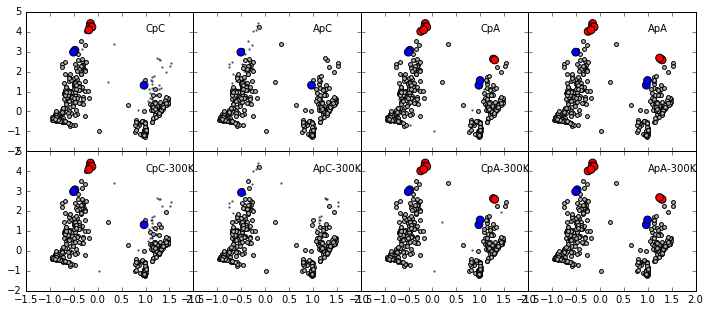

In [385]:
from functools import reduce
ix=0;iy=1
f, axes = plt.subplots(nmols/4,4, \
        figsize=(12,5),sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
for imol in range(nmols):
    M=multi_M[imol]
    avg_lppi_cl=multi_avg_lppi_cl[imol][:,0]
    ndx_lppi=np.where(avg_lppi_cl<0.4)[0]
    #print ndx_lppi
    avg_gamma_cl=multi_avg_gamma_cl[imol][:,0]
    avg_dih_cl=multi_avg_dih_cl[imol]
    ndx_gamma=np.where((avg_gamma_cl*180/np.pi)>150)[0]    
    #print ndx_gamma
    #ndx_chi1=np.where((avg_dih_cl[:,18]*180/np.pi)>0)[0]
    #ndx_chi2=np.where((avg_dih_cl[:,19]*180/np.pi)>0)[0]
    ndx_chi1=np.where((avg_dih_cl[:,18]*180/np.pi)>-1000)[0]
    ndx_chi2=np.where((avg_dih_cl[:,19]*180/np.pi)>-1000)[0]
    
    cs=[]
    for ic in range(M.nstates):
        #if (avg_dih_cl[ic,18]*180/np.pi)>0:
        if (avg_dih_cl[ic,19]*180/np.pi)>0:
            c='red'
        else:
            c='blue'
        cs.append(c)
    cs=np.array(cs)

    ndx=reduce(np.intersect1d,[ndx_gamma,ndx_lppi,ndx_chi1,ndx_chi2])
    print multi_names[imol],M.active_set[ndx]
    dump_dist=np.zeros(M.nstates)
    dump_dist[ndx]+=1
    dump_dist/=np.sum(dump_dist)
    dump_frames=M.sample_by_distributions([dump_dist],200)[0]
    #outfile = multi_names[imol]+'_frames-Zpp.xtc'
    #outfile = multi_names[imol]+'_frames-Zpm.xtc'
    #outfile = multi_names[imol]+'_frames-Zmp.xtc'
    #outfile = multi_names[imol]+'_frames-Zmm.xtc'
    #coor.save_traj(multi_inpXout[imol], dump_frames, outfile=outfile)
    ax=axes[imol/4,imol%4]
    ax.text(1,4,multi_names[imol])
    ax.scatter(cl_centers[:,ix],cl_centers[:,iy],s=2,alpha=0.5)
    ax.scatter(cl_centers[M.active_set,ix],cl_centers[M.active_set,iy],s=15,c='0.7')
    ax.scatter(cl_centers[M.active_set[ndx],0],cl_centers[M.active_set[ndx],1],c=cs[ndx],s=60)

From the plot above we can identify the microstates corresponding to the "Z-motifs".

We colored in red the states with $\chi_2>0$, in blue the ones with $\chi_2<0$. $\chi_1$ is positive on the right, negative on the left.

In the plots below we look more in detail a the values of the observables that we are studying, in the fist-2-TICs space

CpC
ApC
CpA
ApA
CpC-300K
ApC-300K
CpA-300K
ApA-300K


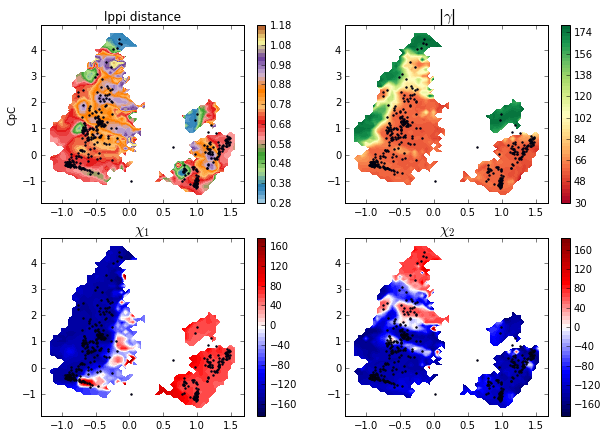

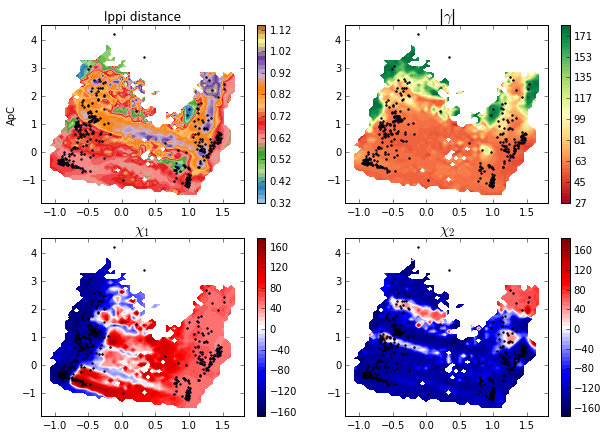

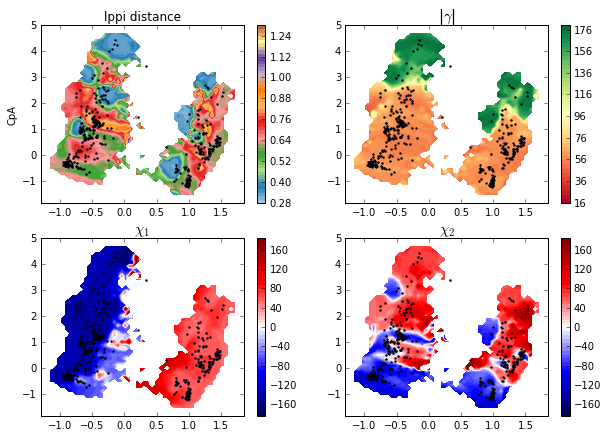

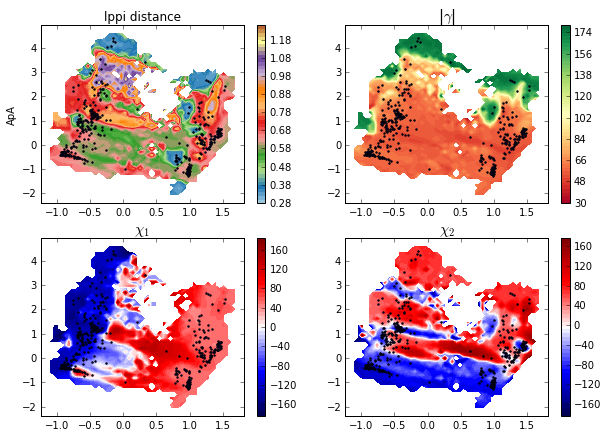

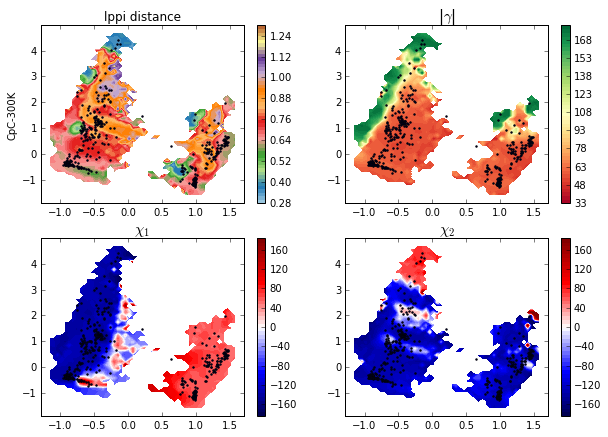

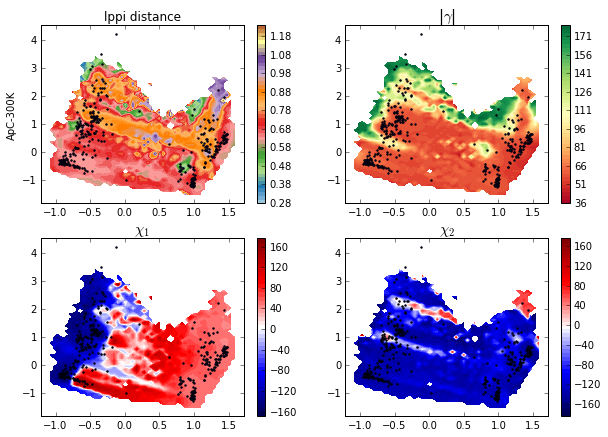

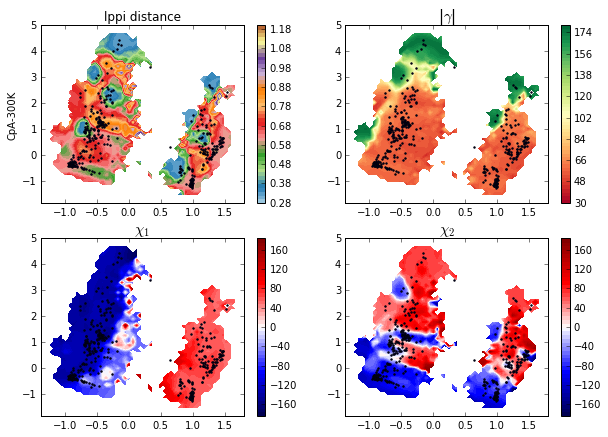

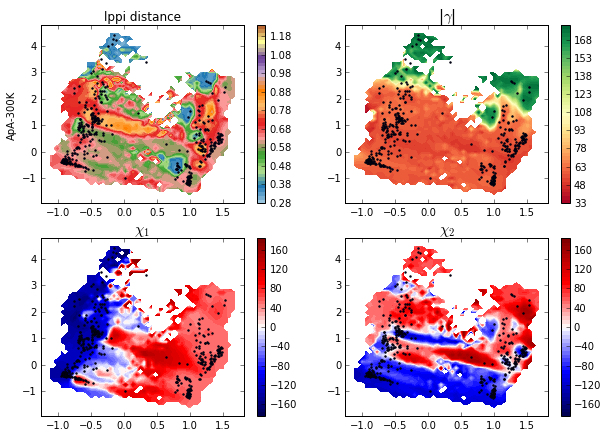

In [380]:
ix=0;iy=1
for imol in range(nmols):
    M=multi_M[imol]
    trajtot_lppi=np.concatenate(multi_traj_lppi[imol])[:,0]
    trajtot_chi1=np.concatenate(multi_traj_dih[imol])[:,18]/np.pi*180
    trajtot_chi2=np.concatenate(multi_traj_dih[imol])[:,19]/np.pi*180
    trajtot_tic=np.concatenate(multi_tica_traj[imol])[:,:]
    trajtot_gamma=np.concatenate(multi_traj_dih[imol])[:,3]/np.pi*180

    plt.figure(figsize=(10,7))
    plt.subplot2grid((2,2),(0,0)); plt.title('lppi distance')
    plt.ylabel(multi_names[imol])
    F,extent=my.plot_3traj(M,trajtot_tic[:,0],trajtot_tic[:,1],trajtot_lppi)
    CS=plt.contourf(F.T, 50, cmap=plt.cm.Paired, extent=extent);cbar = plt.colorbar(CS)
    plt.scatter(cl_centers[M.active_set,ix], cl_centers[M.active_set,iy],s=2)
    plt.subplot2grid((2,2),(0,1)); plt.title(r'|$\gamma$|',fontsize=15)
    F,extent=my.plot_3traj(M,trajtot_tic[:,0],trajtot_tic[:,1],np.abs(trajtot_gamma))
    CS=plt.contourf(F.T, 50, cmap=plt.cm.RdYlGn, extent=extent);cbar = plt.colorbar(CS)
    plt.scatter(cl_centers[M.active_set,ix], cl_centers[M.active_set,iy],s=2)
    plt.subplot2grid((2,2),(1,0)); plt.title(r'$\chi_1$',fontsize=15)
    F,extent=my.plot_3traj(M,trajtot_tic[:,0],trajtot_tic[:,1],trajtot_chi1)
    CS=plt.contourf(F.T, 50, cmap=plt.cm.seismic, extent=extent); cbar = plt.colorbar(CS)
    plt.scatter(cl_centers[M.active_set,ix], cl_centers[M.active_set,iy],s=2)
    plt.subplot2grid((2,2),(1,1)); plt.title(r'$\chi_2$',fontsize=15)
    F,extent=my.plot_3traj(M,trajtot_tic[:,0],trajtot_tic[:,1],trajtot_chi2)
    CS=plt.contourf(F.T, 50, cmap=plt.cm.seismic, extent=extent);cbar = plt.colorbar(CS)
    plt.scatter(cl_centers[M.active_set,ix], cl_centers[M.active_set,iy],s=2)
    print multi_names[imol]

# 4 - Autocorrelation times

Here we compute the autocorrelation time of the stacking score defined in [Condon et al. 2015].
This quantity should be a rough approximation of the intensity of UV absorption, thus the autocorrelation time should correspond to the relaxation timescales measured in [Porschke, 1978]

In [24]:
import stackdef as stack
multi_feat_stack=[];multi_traj_stack=[]
for imol in range(nmols):
    feat_stack=coor.featurizer(multi_topfiles[imol])
    feat_stack.add_custom_func(stack.get_stack_score,1,0,1)
    multi_feat_stack.append(feat_stack)
    traj_stack=coor.load(multi_trajfiles[imol],feat_stack,chunk_size=500)
    multi_traj_stack.append(traj_stack)

getting output of FeatureReader: 100% (1408/1408) [################] eta 00:00 -

In [25]:
multi_avg_stack_cl=[]
for imol in range(nmols):
    inp_stack=coor.source(multi_trajfiles[imol],multi_feat_stack[imol],chunk_size=500)
    traj_stack=multi_traj_stack[imol]
    M=multi_M[imol]
    avg_stack_cl=my.average_by_state(M,inp_stack,stride=1,traj=traj_stack)
    multi_avg_stack_cl.append(avg_stack_cl)

Obtaining file info: 100% (16/16) [################################] eta 00:01 -

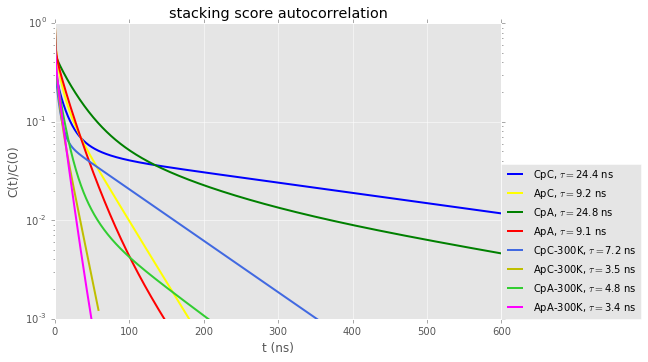

In [30]:
with plt.style.context(('ggplot')):
    plt.figure(figsize=(8,5.3))
    for imol in range(nmols):
        avg_stack=multi_avg_stack_cl[imol]
        M=multi_M[imol]
        media_sq=np.dot(avg_stack[:,0],M.stationary_distribution)**2
        times,corr=M.correlation(avg_stack[:,0])
        acorr=(corr-media_sq)/(corr[0]-media_sq)
        t_corr=(0.5+np.sum(acorr[1:]))*M.lag/100
        plt.plot(times/100,acorr,label=r'%s, $\tau=$%.1f ns'%(multi_names[imol],t_corr)\
                 ,color=multi_colors[imol],lw=2)
    plt.ylabel('C(t)/C(0)');plt.xlabel('t (ns)')
    plt.yscale('log')
    plt.xlim(0,600);  plt.ylim(0.001,1.)
    plt.title('stacking score autocorrelation')
    plt.legend(loc=(1,0),fontsize=10)

We can compute uncertainties using again the Bayesian sampling of transition matrices:

In [27]:
multi_tau_a=[]
for imol in range(len(multi_names)):
    M=multi_M[imol]
    avg_stack_cl=multi_avg_stack_cl[imol]
    roba=np.tensordot(M.eigenvectors_left()[1:,:],avg_stack_cl,axes=[1,0])
    tau_a=np.sum( (roba**2)*M.timescales()[:,np.newaxis] ,axis=0)\
    /np.sum(roba**2,axis=0)
    multi_tau_a.append(tau_a[0])

In [28]:
multi_tau_a_bayes=[]
for imol in range(len(multi_names)):
    BM=multi_BM[imol]
    avg_stack_cl=multi_avg_stack_cl[imol]
    taus=[]
    for M in BM.samples:
        roba=np.tensordot(M.eigenvectors_left()[1:,:],avg_stack_cl,axes=[1,0])
        tau_a=np.sum( (roba**2)*M.timescales()[:,np.newaxis] ,axis=0)\
            /np.sum(roba**2,axis=0)
        taus.append(tau_a)
    taus=np.array(taus)
    multi_tau_a_bayes.append(np.std(taus))
multi_tau_a_bayes=np.array(multi_tau_a_bayes)
multi_tau_a_bayes.shape

(8,)

In [29]:
for imol in range(len(multi_names)):
    m=multi_tau_a[imol]
    s=multi_tau_a_bayes[imol]
    name=multi_names[imol]
    print '%s \t %2.2f +- %1.3f ns' % (name,m/100,s/100)

CpC 	 24.48 +- 2.958 ns
ApC 	 9.18 +- 0.263 ns
CpA 	 24.80 +- 0.965 ns
ApA 	 9.11 +- 0.144 ns
CpC-300K 	 7.21 +- 0.465 ns
ApC-300K 	 3.45 +- 0.033 ns
CpA-300K 	 4.75 +- 0.106 ns
ApA-300K 	 3.38 +- 0.051 ns
